# Phân tích đặc trưng quan trọng của Best_model

Note:
---

Đây là kết quả vẽ và phân tích dựa trên một lần thực nghiệm, những lần chạy khác có thể dẫn đến sự thay đổi `BEST_MODEL` và có thể gấy sai lệch trong nội dung phân tích sẵn có ở bên trong `markdown`


In [5]:
import os, sys, joblib, re
from datetime import datetime
from pathlib import Path
import pandas as pd

print(os.getcwd())
sys.path.append(os.path.abspath(".."))

from src.visualizer.plots import (
    boxplot,
    countplot,
    piechart,
    scatterplot,
    residualplot,
    histogram,
    heatmap,
    KDEplot,
    linechart,
    feature_importance_plot,
    shap_summary_plot,
    PDP_plot,
)

e:\FinalTermProject_Python4DS\notebooks


In [6]:
MODEL_DIR = os.path.join(os.path.abspath(".."),"models")
DATA_DIR = os.path.join(
    os.path.abspath(".."), "X_train_saver"
)

Note:
---
- **Nên thực hiện train `cả 5 models` bằng file `main.py` trong thư mục `src` trước** vì X_train_saver sẽ được xoá và tạo lại sau mỗi lần train.

- Sẽ chọn ra model BEST_OF_5_MODELS_`<ModelName>`_YYYYMMDD_HHMM.joblib được train gần nhất và sẽ lấy ra `<ModelName>` để có thể đọc được file X_train tương ứng trong thư `X_train_saver`.

In [7]:
def find_latest_model(models_dir="../models"):
    """
    Locate the most recent model file in the specified directory.

    Expected filename format:
    BEST_OF_5_MODELS_<ModelName>_YYYYMMDD_HHMM.joblib

    Returns:
        tuple: (filename, model_name)
    Raises:
        FileNotFoundError: If the directory does not exist or no valid model file is found.
    """
    models_dir = Path(models_dir)

    if not models_dir.exists():
        raise FileNotFoundError(f"Models directory not found: {models_dir}")

    # Updated pattern with MODELS_
    pattern = r"BEST_OF_5_MODELS_(.+)_(\d{8}_\d{4})\.joblib"

    newest_file = None
    newest_timestamp = None
    newest_model_name = None

    for fname in os.listdir(models_dir):
        match = re.match(pattern, fname)
        if match:
            model_name = match.group(1)
            timestamp_str = match.group(2)

            # Convert timestamp to datetime object
            timestamp_dt = datetime.strptime(timestamp_str, "%Y%m%d_%H%M")

            if newest_timestamp is None or timestamp_dt > newest_timestamp:
                newest_timestamp = timestamp_dt
                newest_file = fname
                newest_model_name = model_name

    if newest_file is None:
        raise FileNotFoundError(
            "No model file found matching: BEST_OF_5_MODELS_<ModelName>_YYYYMMDD_HHMM.joblib"
        )

    return newest_file, newest_model_name


def load_latest_pipeline():
    """
    Load the most recent trained pipeline and its corresponding training data.

    The function:
      - Detects the newest model file using `find_latest_model()`
      - Loads the pipeline (preprocessor + model)
      - Loads the saved training dataset matching the model name
      - Ensures the src folder is included in sys.path

    Returns:
        tuple: (pipeline, preprocessor, trained_model, X_train)
    Raises:
        FileNotFoundError: If the model file or training data CSV is missing.
    """
    # Find latest model file
    model_file, model_name = find_latest_model()

    model_path = Path("../models") / model_file
    data_path = Path("../X_train_saver") / f"{model_name}.csv"

    print(f"Found latest model: {model_file}")
    print(f"Model path: {model_path}")
    print(f"CSV path: {data_path}")

    # Add src folder to sys.path
    src_dir = Path("../src").resolve()
    if str(src_dir) not in sys.path:
        sys.path.append(str(src_dir))
        print(f"Added {src_dir} to sys.path.")

    # Load pipeline
    pipeline = joblib.load(model_path)
    preprocessor = pipeline[:-1]
    loaded_model = pipeline[-1]

    # Load training data CSV
    if not data_path.exists():
        raise FileNotFoundError(f"CSV file not found: {data_path}")

    X_train = pd.read_csv(data_path)
    print("Loaded training data successfully.")

    return pipeline, preprocessor, loaded_model, X_train

In [8]:
pipeline, preprocessor, model, X_train = load_latest_pipeline()
X_train.head(5)

Found latest model: BEST_OF_5_MODELS_LGBMRegressor_20251208_2135.joblib
Model path: ..\models\BEST_OF_5_MODELS_LGBMRegressor_20251208_2135.joblib
CSV path: ..\X_train_saver\LGBMRegressor.csv
Added E:\FinalTermProject_Python4DS\src to sys.path.
Loaded training data successfully.


,area,condo_complex,bathrooms,new_address,legal_status,furniture_state,frontage,floors,bedrooms
0,54.1,0,4.0,"Gò Vấp, Hồ Chí Minh",Have certificate,Full,4.15,5.0,3.0
1,40.0,0,3.0,"Hồng Bàng, Hải Phòng",Have certificate,NaN,4.00,3.0,3.0
2,100.0,0,1.0,"Quận 9, Hồ Chí Minh",NaN,Full,5.00,1.0,2.0
3,30.0,0,3.0,"Tây Hồ, Hà Nội",Have certificate,Full,NaN,5.0,3.0
4,63.4,0,3.0,"Quận 8, Hồ Chí Minh",Have certificate,NaN,4.00,3.0,4.0


In [9]:
X_data_new = preprocessor.transform(X_train)
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Case older pipeline not support get_feature_names_out
    feature_names = [f"Feature_{i}" for i in range(X_data_new.shape[1])]

# Recreate dataframe
X_fit = pd.DataFrame(X_data_new, columns=feature_names)
X_fit.head(5)

,num__area,num__frontage,num__bedrooms,num__floors,num__condo_complex,cat_onehot__legal_status_Have certificate,cat_onehot__legal_status_Sale contract,cat_onehot__legal_status_missing,cat_onehot__furniture_state_Basic,cat_onehot__furniture_state_Full,cat_onehot__furniture_state_missing,target_enc__new_address,target_enc__bathrooms,target_enc__bedrooms
0,-0.297614,-0.254196,-0.349784,1.294712,-0.370211,1.0,0.0,0.0,0.0,1.0,0.0,6.422269,6.374343,5.369469
1,-0.589168,-0.297204,-0.349784,-0.292984,-0.370211,1.0,0.0,0.0,0.0,0.0,1.0,4.804416,5.546946,5.369469
2,0.651489,-0.010483,-1.182122,-1.880681,-0.370211,0.0,0.0,1.0,0.0,1.0,0.0,6.586007,4.277775,4.421087
3,-0.795944,-0.153843,-0.349784,1.294712,-0.370211,1.0,0.0,0.0,0.0,1.0,0.0,6.926041,5.546946,5.369469
4,-0.105312,-0.297204,0.482555,-0.292984,-0.370211,1.0,0.0,0.0,0.0,0.0,1.0,5.832140,5.546946,6.433257


100%|===================| 19323/19346 [02:27<00:00]        

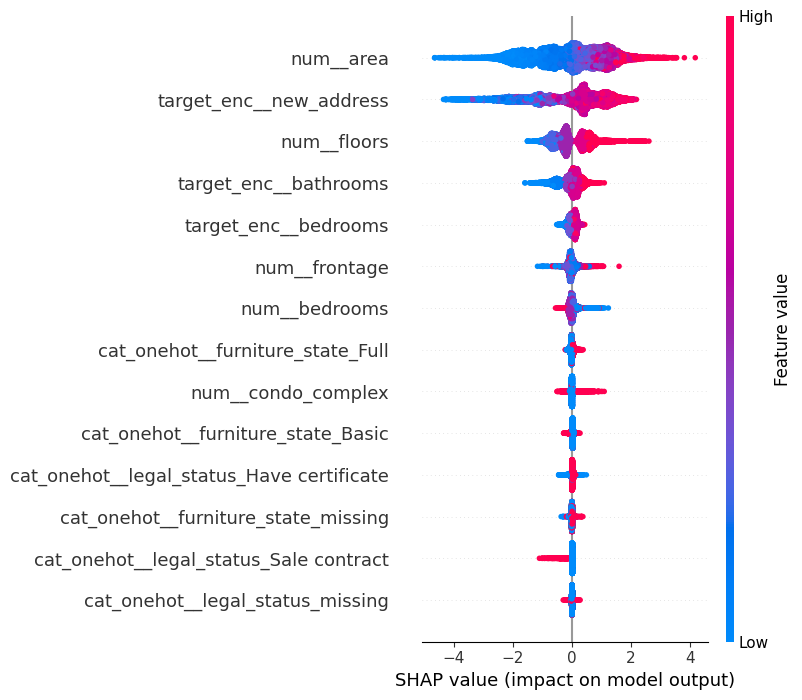

In [10]:
shap_summary_plot(pipeline[-1], X_fit)

***NHẬN XÉT:***
* *num_area (Diện tích):*  Là yếu tố **quan trọng thứ 1**. Dải màu trả rất rộng từ âm sang dương
    * *Nhận xét:* **Tương quan thuận mạnh.** 
        - **Cứ nhà to (Màu Đỏ):** Là mô hình tự động "cộng thêm một đống tiền" vào giá trị căn nhà (đẩy tít sang bên phải).
        - **Còn nhà bé (Màu Xanh):** Là bị "trừ bớt tiền" đi ngay lập tức (kéo tụt về bên trái). <br>
        $\Rightarrow$ **Diện tích càng lớn thì giá càng tăng.**

* *target_enc__new_address (Quận - Thành phố):* Là yếu tố **quan trọng thứ 2.** Feature này đóng vai trò như một **hệ số điều chỉnh giá theo địa lý.**
    * *Phía bên phải (Nhóm Quận giá cao):* Tập trung toàn bộ vào các điểm **Màu đỏ**. **Vị trí đắc địa** sẽ trực tiếp **cộng thêm** giá trị lớn cho ngôi nhà.

    * *Phía bên trái (Nhóm Quận giá thấp):* Tập trung về phía âm. **Vị trí xa trung tâm** sẽ **trừ bớt** giá trị so với mức cơ sở

    * *Hiệu quả kỹ thuật:* **Target Encoding** đã giúp mô hình **phân biệt rạch ròi giữa giá trị bất động sản dựa trên khu vực** với biên độ ảnh hưởng rộng thứ 2. <br>

    $\Rightarrow$ **Nhà có vị trí địa lý thuận lợi (gần trung tâm, các quận phát triển) thì có giá tiền càng cao và ngược lại.**

* *num_floors (Số tầng):* Là yếu tố **quan trọng thứ 3.**
    * *Nhận xét:* Nhà càng **nhiều tầng** thì giá **càng tăng**

* *Số lượng phòng tắm (bathrooms)* có ảnh hướng lớn hơn *phòng ngủ (bedrooms)*

* **Hiện tượng Đa cộng tuyến tại** *num_bedrooms*: Dù là số lượng phòng ngủ, nhưng **giá trị cao** (nhiều phòng) lại có **SHAP quanh mức 0 hoặc âm**. Điều này phản ánh **đa cộng tuyến** với **Diện tích (num_area)**. <br>
$\Rightarrow$ Do diện tích là yếu tố tiên quyết, việc **tăng số phòng ngủ** trên một **diện tích cố định** ***không*** làm tăng giá trị, thậm chí làm không gian bị chia nhỏ, chật chội hơn nên **mô hình không đánh giá cao.**

* *Yếu tố tiện ích (num_condo_complex):* Tác động **tích cực** rõ rệt. Việc **nằm trong khu phức hợp** (màu đỏ) giúp **kéo** giá trị bất động sản lên **cao hơn** so với **nhà lẻ.**

* *Nội thất và Pháp lý:*
    * **Nội thất:** Ảnh hưởng khiêm tốn nhưng logic. Nhà *đầy đủ* nội thất nằm ở phía dương, trong khi nội thất *cơ bản* có xu hướng **trung tính hoặc giảm nhẹ**. Tức là, *nhà có đầy đủ nội thất thì giá càng cao, còn nhà có nội thất cơ bản thì giá nhà tương đối.*
    
    * **Pháp lý:** Nhà chỉ có **Hợp đồng mua bán (_Sale contract)** có **SHAP âm**, phản ánh **rủi ro pháp lý** làm **giảm** giá trị ngôi nhà. Ngược lại, có **(_Have certificate)** giúp **giữ hoặc tăng** giá nhẹ.




In [11]:
features = X_fit.columns.tolist()
features

['num__area',
 'num__frontage',
 'num__bedrooms',
 'num__floors',
 'num__condo_complex',
 'cat_onehot__legal_status_Have certificate',
 'cat_onehot__legal_status_Sale contract',
 'cat_onehot__legal_status_missing',
 'cat_onehot__furniture_state_Basic',
 'cat_onehot__furniture_state_Full',
 'cat_onehot__furniture_state_missing',
 'target_enc__new_address',
 'target_enc__bathrooms',
 'target_enc__bedrooms']

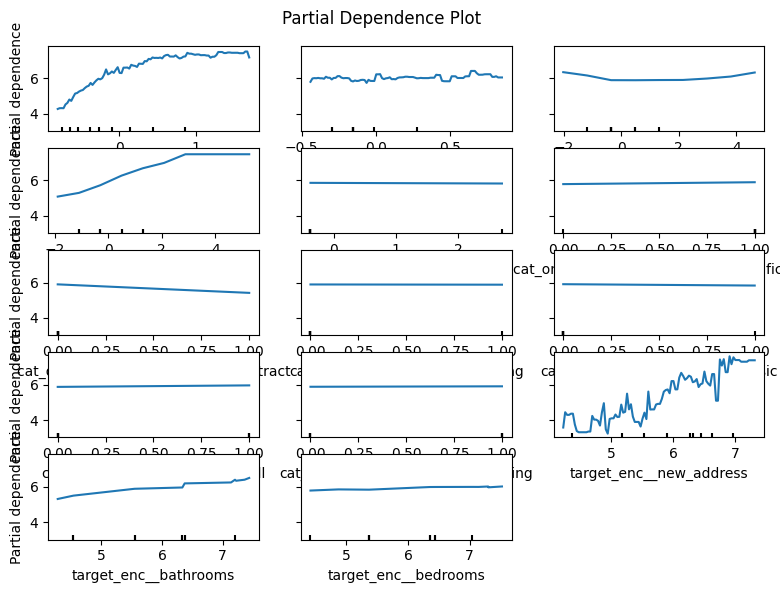

In [12]:

PDP_plot(model, X_fit, features)

***NHẬN XÉT:***
1. **Nhóm có xu hướng rõ ràng:**
    - *num_area (HÀNG 1, Ô 1):*
        + **Xu hướng:** Đường PDP tăng dốc ở đoạn đầu (diện tích nhỏ). Ở đoạn giữa và cuối (diện tích lớn), độ dốc giảm dần, đường thoải và gần như đi ngang.
        + **Nhận xét:** Đây là quy luật **"Hiệu dụng biên giảm dần (Diminishing Marginal Returns)** tức là **mức độ tăng thêm** của giá trị dự đoán **giảm dần** theo thời gian.
        + **Ý nghĩa:** 
            * Lúc *diện tích nhỏ* $\rightarrow$ *tăng thêm diện tích làm giá trị tăng mạnh.*
            * Lúc *diện tích lớn* $\rightarrow$, *giá trị tăng thêm không còn nhiều như lúc đầu.*
    
    - *num_floors (HÀNG 2, Ô 1):*
        + **Xu hướng:** Đường PDP tăng dần theo dạng **bậc thang**
        + **Nhận xét:** Đây là mối quan hệ **Tương quan thuận rành mạch.**
        + **Ý nghĩa:**
            * *Mỗi khi xây thêm một tầng $\rightarrow$ giá trị căn nhà được cộng thêm một mức cụ thể.*
            * *Xu hướng này rất ổn định, không bị bão hòa nhanh như diện tích.*
    
    - *target_enc_new_address (HÀNG 4, Ô 3):*
        + **Xu hướng:** Đường PDP **dốc đứng hướng lên trên, có độ gập ghềnh (dao động) lớn.**
        + **Nhận xét:** Thể hiện **Độ nhạy giá cực cao** đối với vị trí.
        + **Ý nghĩa:** 
            * *Chuyển từ quận rìa vào quận trung tâm $\rightarrow$ giá nhà tăng vọt theo cấp số nhân.*
            * *Độ dốc lớn nhất trong tất cả các biểu đồ $\rightarrow$ "đòn bẩy" mạnh nhất để thay đổi giá dự đoán.*

    - *target_enc_bathrooms (HÀNG 5, Ô 1):*
        + **Xu hướng:** Đường PDP đi **lên nhẹ và thoải.**
        + **Nhận xét:** Tương quan thuận nhưng ở mức độ **Phụ trợ.**
        + **Ý nghĩa:** 
            * *Nhà nhiều phòng tắm (hoặc khu vực có thiết kế nhiều WC) thường là nhà cao cấp hơn $\rightarrow$ giá cao hơn.*
            * *Tuy nhiên, độ dốc thấp $\rightarrow$ số lượng phòng tắm không phải là* **yếu tố chính**  *quyết định giá như Diện tích hay Vị trí.*

2. **Nhóm "Bình ổn" hoặc "Yếu":**
    - *num_bedrooms (HÀNG 1, Ô 3):*
        + **Xu hướng:** Đường PDP **đi ngang**, thậm chí có xu hướng **hơi võng xuống** ở phần cuối *(khi số phòng ngủ > 4-5)*.
        + **Nhận xét:** Thể hiện sự **Bão hòa giá trị hoặc tác động tiêu cực do Đa cộng tuyến**.
        + **Ý nghĩa:**
            * *Số lượng phòng ngủ đạt đến một mức độ nào đó (thường là 3-4 phòng) là đủ.*
            * *Thêm phòng ngủ mà không tăng diện tích $\rightarrow$ không làm tăng giá trị, thậm chí làm giảm giá do không gian bị chia nhỏ, bí bách.*
    
    - *Các biến one-hot còn lại (CÁC Ô CÒN LẠI):*
        + **Xu hướng:** Hầu hết là các đường **thẳng nằm ngang.**
        + **Nhận xét:** Tác động **Nhị phân** bị **lu mờ bởi tỷ lệ trục tung.**
        + **Ý nghĩa:** 
            * Vì *num_area* và *target_enc_new_address* làm giá biến động quá mạnh, nên trục giá trên biểu đồ phải phóng to ra để chứa hết mức dao động đó. *Các biến One-hot chỉ làm thay đổi giá trị nhỏ, khi đặt chung trên trục đã bị phóng to như vậy, đường của chúng nhìn giống như đường thẳng.
            * Tuy nhiên, **không có nghĩa là các biến này vô ích, không có ý nghĩa** mà là nó **ít quan trọng hơn nhiều** so với *Diện tích và Vị trí.*
        

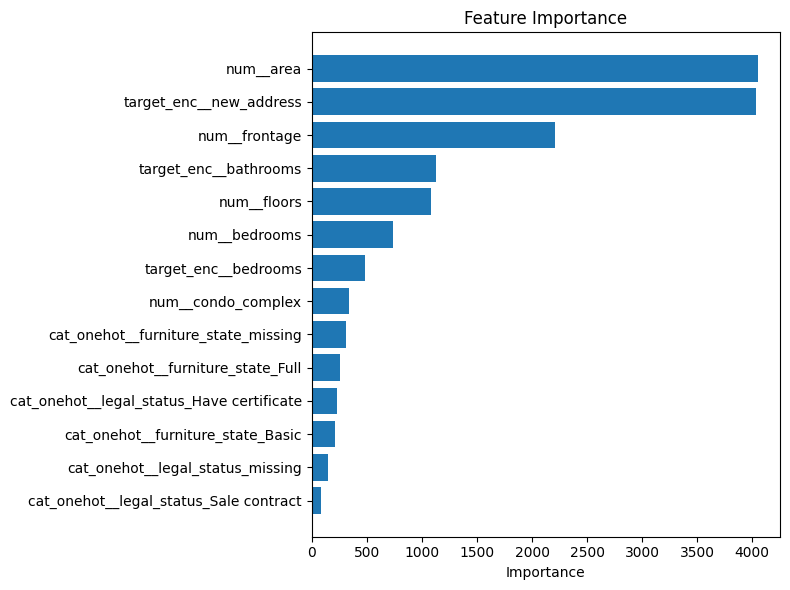

In [13]:
feature_importance_plot(model, features)

***NHẬN XÉT:***
1. **Nhóm Top Tier:**
    - *num_area (Diện tích) & target_enc_new_address (Vị trí):*
        + **Thứ hạng:** Top **1** và Top **2**
        + **Nhận xét:** Đây là hai yếu tố **cực kỳ quan trọng.** Nếu không biết hai cái này, khó có thể đưa ra quyết định.
        + **Ý nghĩa:** *Khi khách hỏi mua nhà, chắc chắn điều mà tư vấn viên hỏi đầu tiên là **"Nhà rộng bao nhiêu?"** và **"Nhà ở quận nào?"**, hai yếu tố là thứ khiến tư vấn viên quyết định nên đưa ra những căn nhà nào phù hợp.*

2. **Điểm cần lưu ý:**
    - *num_frontage (Mặt tiền):*
        + **Thứ hạng:** Đứng thứ **3**, cao hơn cả số tầng và toilet
        + **Nhận xét:** Có sự khác biệt giữa "Tần suất" và "Độ lớn tác động".
        + **Ý nghĩa:** 
            * Ở biểu đồ SHAP và PDP trước đó, num__frontage không quá nổi bật. Tuy nhiên, ở đây nó lại rất quan trọng.
            * **Giải thích**: Mô hình **sử dụng mặt tiền rất nhiều lần** để **tinh chỉnh** giá cho chuẩn xác, chứ *không* phải là động lực chính để **thổi** giá lên cao. Tức là, **Mặt tiền** được dùng để **"mặc cả từng đồng"** cho chuẩn giá, còn **Diện tích** dùng để **"định giá ngàn vàng".**

3. **Nhóm Middle Tier:**
    - *target_enc_bathrooms & num_floors &num_bedrooms:*
        + **Thứ hạng:** Ở **giữa**
        + **Nhận xét"** Các yếu tố **gia tăng giá trị ổn định.**
        + **Ý nghĩa:** *Sau khi chốt xong diện tích và vị trí, tư vấn viên tiếp tục hỏi đến **số lượng tầng, toilet, phòng ngủ**. Nếu có **nhiều thì cộng thêm tiền** vào còn **ít thì trừ bớt** đi giá căn nhà đó.*

4. **Nhóm Bottom Tier:**
    - *Các yếu tố còn lại:*
        + **Nhận xét:** Cái cột thấp ở đây **không phải là "không quan trọng"**, mà là vì nó **"dễ kiểm tra"** nên mô hình xử lý nhanh gọn lẹ!
        + **Ý nghĩa:** Với chuyện **giấy tờ/nội thất:** Hỏi **1 câu là chốt được vấn đề**.

$\Rightarrow$ Mô hình này ***khôn y hệt người thật***: Đi mua nhà là cứ phải nhìn **Đất rộng - Quận ngon** trước đã, rồi mới bắt đầu **soi kỹ mặt tiền** để **ép giá**, cuối cùng mới **đếm tầng đếm phòng** để **chốt giá**.
